In [19]:
# Common imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

# Networking/packet analysis
import pyshark
import scapy.all as scapy
import networkx as nx
import random

from ipywidgets import interact, IntSlider, FloatSlider


# Helper: inline plots
%matplotlib inline


# CSMA/CD Simulator — Contention and Collision Behavior

**Goal:** Model how multiple stations share a single channel, detect collisions, and apply exponential back-off.

**Connection to previous labs:**
- From WireScope: reflections on a shared medium cause collisions.
- From ARP Scope Analyzer: hosts use broadcast frames on that same medium.
- Now: we quantify how often those frames collide and how CSMA/CD keeps the medium usable.


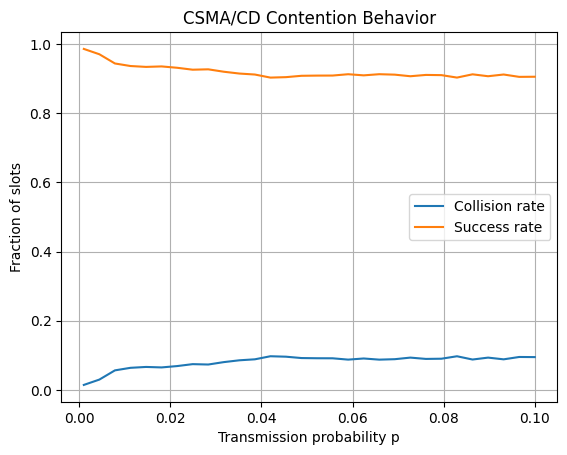

In [20]:
def csma_cd_sim(stations=10, slots=10000, p_tx=0.01, max_backoff=10):
    """Simulate CSMA/CD channel with given number of stations and number of slots."""
    successes = collisions = 0
    backoff = np.zeros(stations, dtype=int)

    for t in range(slots):
        ready = [i for i in range(stations) if backoff[i]==0 and random.random() < p_tx]
        if len(ready) == 1:
            successes += 1
        elif len(ready) > 1:
            collisions += 1
            # exponential backoff for collided stations
            for i in ready:
                backoff[i] = random.randint(1, 2**min(max_backoff, 10))
        # decrement timers
        backoff = np.maximum(backoff-1, 0)
    return successes, collisions

ps = np.linspace(0.001, 0.1, 30)
succ, coll = [], []
for p in ps:
	s, c = csma_cd_sim(stations=20, p_tx=p)
	succ.append(s); coll.append(c)

plt.plot(ps, np.array(coll)/(np.array(coll)+np.array(succ)), label="Collision rate")
plt.plot(ps, np.array(succ)/(np.array(coll)+np.array(succ)), label="Success rate")
plt.xlabel("Transmission probability p")
plt.ylabel("Fraction of slots")
plt.title("CSMA/CD Contention Behavior")
plt.legend(); plt.grid(True)
plt.show()

### 🧠 Understanding the Plot
- At very low *p*, collisions ≈ 0 but channel under-utilized.
- As *p* rises, collisions increase rapidly — too many talkers at once.
- Peak throughput ≈ 30–40 % for many nodes on classic Ethernet.
- Full-duplex switched Ethernet solves this by eliminating shared media and CSMA/CD entirely.


In [25]:

def run_interactive(stations=10, p_tx=0.02):
    s, c = csma_cd_sim(stations=stations, p_tx=p_tx)
    print(f"Stations={stations}, p_tx={p_tx:.3f}, Successes={s}, Collisions={c}, Collision rate={c/(s+c):.2%}")

interact(
    run_interactive,
    stations=IntSlider(value=5, min=1, max=50, step=1, description="Stations"),
    p_tx=FloatSlider(value=0.02, min=0.001, max=0.1, step=0.001, description="Tx prob")
);


interactive(children=(IntSlider(value=5, description='Stations', max=50, min=1), FloatSlider(value=0.02, descr…

| Concept                     | Physical meaning                      | Networking consequence                              |
| --------------------------- | ------------------------------------- | --------------------------------------------------- |
| Shared medium               | One electrical channel                | Many nodes contend for same wire                    |
| Reflection (from WireScope) | Overlapping signals                   | Collision detected by voltage spike                 |
| Jam signal                  | Artificial burst sent after collision | Ensures all nodes detect the event                  |
| Backoff timer               | Random wait after collision           | Reduces re-collision probability                    |
| Slot time (512 bits)        | Propagation limit                     | Defines Ethernet’s max length (≈ 100 m for 10 Mb/s) |


1. What physical limitation (studied in WireScope) dictates the minimum Ethernet slot time?
2. Why does CSMA/CD require nodes to *listen* while transmitting?
3. How does doubling cable length affect collision probability?
4. Why is CSMA/CD disabled on modern switched Ethernet?

- Plot showing collision vs success rate.
- Short paragraph explaining optimal *p* range for maximum throughput.
- Table linking physical effects (reflection delay) to protocol timing.

**Summary — From Wire Physics to MAC Behavior**
- Reflections (WireScope) → collisions here.
- Propagation delay defines CSMA/CD slot time.
- Random backoff and jam signals keep the network stable.
- Switched/full-duplex Ethernet removes this bottleneck entirely.
